<a href="https://colab.research.google.com/github/bivekpok/DSPS_BPokhrel/blob/main/HW6/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
import math
!pip install george
import george
from george import kernels
from scipy.optimize import minimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for george: filename=george-0.4.0-cp310-cp310-linux_x86_64.whl size=355559 sha256=cca88d4cc6ed2c1aac0409c0540b38d401290bda8110b4a911d971e15814e610
  Stored in directory: /root/.cache/pip/wheels/63/02/e3/24f2361717de09616769d97ed5854b4703d4df49fb1a3a1131
Successfully built george


# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [10]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()
print(df.head())
print(df.shape)
df.tail()

     YEAR    JAN    FEB    MAR    APR    MAY    JUN    JUL    AUG    SEP  \
0  1950.0  23.11  24.20  25.37  23.86  23.03  21.57  20.63  20.15  19.67   
1  1951.0  24.19  25.28  25.60  25.37  24.79  24.69  23.86  22.32  21.44   
2  1952.0  24.52  26.21  26.37  24.73  23.71  22.34  20.89  20.02  19.63   
3  1953.0  24.15  26.34  27.36  27.03  25.47  23.49  22.20  21.45  21.25   
4  1954.0  23.02  25.00  25.33  22.97  21.73  20.77  19.52  19.33  18.95   

     OCT    NOV    DEC  
0  20.03  20.02  21.80  
1  21.77  22.33  22.89  
2  20.40  20.77  22.39  
3  20.95  21.60  22.44  
4  19.11  20.27  21.30  
(61, 13)


,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
56,2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
57,2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
58,2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73
59,2009.0,24.39,25.53,25.48,25.84,24.95,24.09,23.09,22.03,21.48,21.64,21.99,23.21
60,2010.0,24.70,26.16,26.54,26.04,24.75,23.26,21.11,19.49,19.28,19.73,20.44,22.07


In [11]:
df.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1980.000000,24.392131,25.839344,26.247705,25.386557,24.161967,22.833934,21.743934,20.842787,20.583770,20.862295,21.523934,22.693115
std,17.752934,0.913946,0.800560,0.896667,1.126876,1.323505,1.282808,1.228692,1.138723,1.006958,1.054401,1.094229,1.083051
min,1950.000000,22.980000,24.200000,24.470000,22.970000,21.730000,20.770000,19.520000,19.270000,18.950000,19.110000,19.440000,21.050000
25%,1965.000000,23.840000,25.360000,25.600000,24.670000,23.290000,21.840000,21.010000,20.030000,19.850000,20.140000,20.770000,22.030000
50%,1980.000000,24.320000,25.770000,26.090000,25.210000,23.880000,22.540000,21.470000,20.640000,20.500000,20.620000,21.490000,22.500000
75%,1995.000000,24.710000,26.270000,26.890000,25.840000,24.750000,23.280000,22.310000,21.390000,21.230000,21.640000,22.170000,23.210000
max,2010.000000,28.120000,28.820000,29.240000,28.820000,28.370000,27.430000,25.730000,24.950000,24.690000,24.640000,25.850000,27.080000


In [12]:
for i in df[1:3]:
  print(i)
# from intertools import chain
df2 = df.iloc[:,1:]
arr = np.array(df2.values).reshape(-1)

# arr2 = np.arange(arr.shape[0])
# arr2

YEAR
JAN
FEB
MAR
APR
MAY
JUN
JUL
AUG
SEP
OCT
NOV
DEC


In [13]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """

    df2 = df.iloc[:,1:]
    data = np.array(df2.values).reshape(-1)

    time = np.arange(arr.shape[0])
    return time, data



x, y = flatten_dataset(df)

In [14]:
time_data_days = x/12 * 365.25
value_data = y

print(time_data_days.shape)
print(y.shape)

(732,)
(732,)


# 1. Visualize

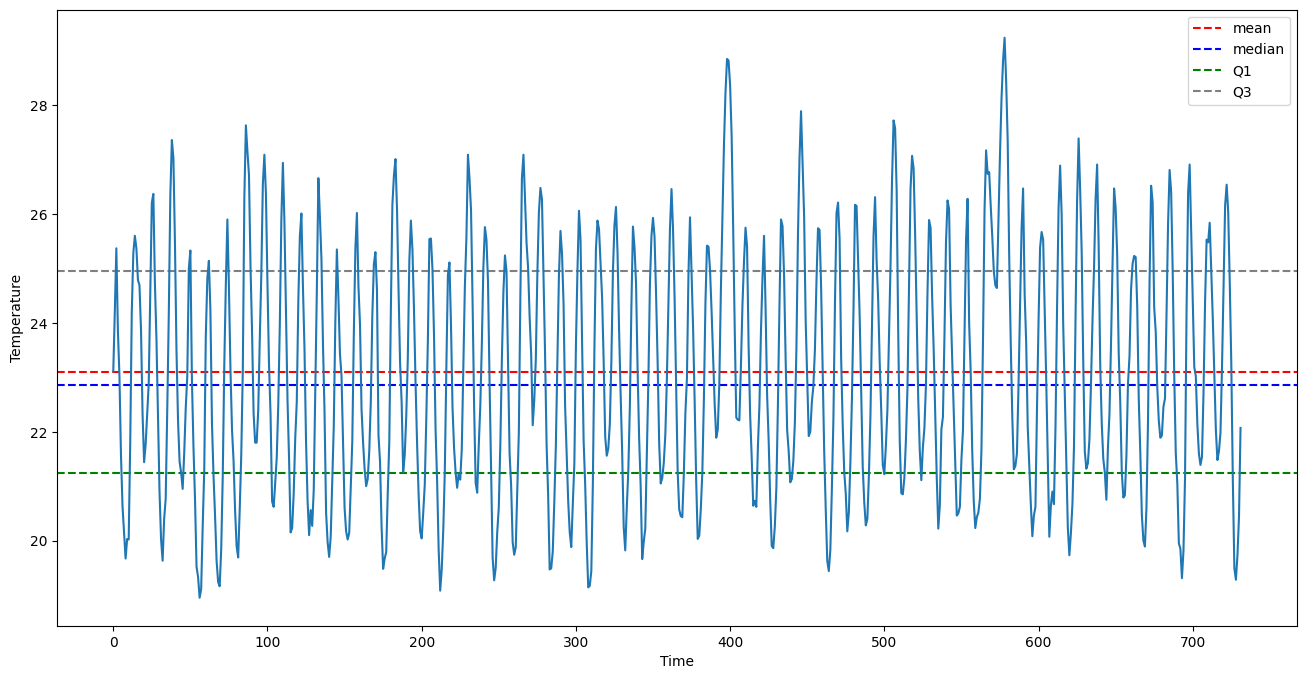

In [15]:
def visualize(df):
  """
  Visualize the El Niño – Sea Surface Temperature dataset.

  You decide the most appropriate way to visualize the dataset.

  Parameters
  ----------
  df : pd.DataFrame
      The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
      from the statsmodels package.

  Returns
  -------
  None
  """
  fig,ax = plt.subplots(figsize = (16,8))
  x, y = flatten_dataset(df)
  ax.axhline(y=y.mean(), color='red', linestyle='--', label='mean')
  ax.axhline(y=np.median(y), color='blue', linestyle='--', label='median')
  ax.axhline(y=np.percentile(y,25), color='green', linestyle='--', label='Q1')
  ax.axhline(y=np.percentile(y,75), color='grey', linestyle='--', label='Q3')


  ax.plot(x,y)
  ax.set_xlabel('Time')
  ax.set_ylabel('Temperature')
  ax.legend()
  plt.show()


visualize(df)

## Fig 1: This is the plot of the temperature at every month in 61 year time from 1950 to 2010. This plot is created in order to see the nature of the temperature over the time. I have potted the horzontal line for median, 25th and 75th percentile to see the skewness of the data if any.

# 2. Gaussian Process Regression (GPR)

In [16]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """

    return np.arange(math.ceil(365.25*81 -31))
    raise NotImplementedError()

t = get_interpolated_time()
t

array([    0,     1,     2, ..., 29552, 29553, 29554])

(27500,) (27500,)
Optimized values: 3.09, 3.69


<ipython-input-17-27061de2fb47>:54: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(time_interp, mean_interp - np.sqrt(std_interp), mean_interp + np.sqrt(std_interp), color='C1', alpha=0.4)


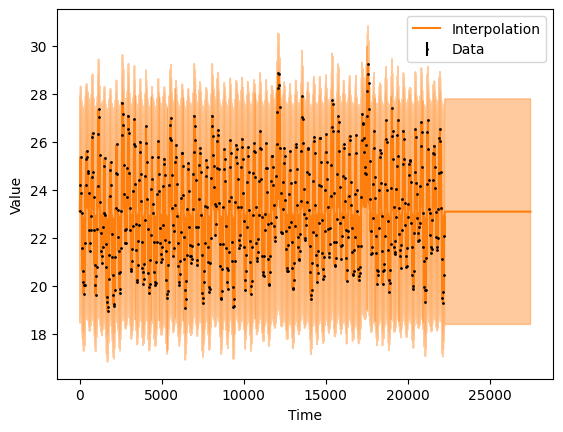

In [17]:
def gaussian_process_regression(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """
    # a, b, c, d = initial_guess
    a, b, c = initial_guess
    # time_data = x
    # value_data = y
    kernel = a * kernels.ExpSquaredKernel(b) +kernels.ConstantKernel(log_constant=c)
    # kernel = a * kernels.CosineKernel(log_period=b) + c * kernels.ExpSquaredKernel(d)
    # kernel = a * kernels.CosineKernel(log_period=b) + kernels.ConstantKernel(log_constant=c)
    # kernel = a * kernels.CosineKernel(log_period=b)

    # Create the GP regression model
    gp = george.GP(kernel)

    # Pre-compute the covariance matrix and optimize the GP hyperparameters
    gp.compute(time)
    gp.get_matrix(x)
    # Define a time grid for interpolation
    time_interp = t[:27500]

    # Perform GP regression to interpolate values at time_interp
    mean_interp, std_interp = gp.predict(data, time_interp, return_var=True)
    print(mean_interp.shape, std_interp.shape )
    optimized_values = gp.get_parameter_vector()
    print(f'Optimized values: {optimized_values[0]:.2f}, {optimized_values[1]:.2f}')

#     # Plot the original data and the GP interpolation
    plt.errorbar(time, data, yerr=0.01, fmt='ok', markersize=1, label='Data')
    plt.plot(time_interp, mean_interp, color='C1', label='Interpolation')
    plt.fill_between(time_interp, mean_interp - np.sqrt(std_interp), mean_interp + np.sqrt(std_interp), color='C1', alpha=0.4)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    # plt.xscale('log')
#     plt.figure(figsize=(240, 8))
    # plt.xlim(100,1550)
    plt.show()


initial_guess = 22, 40, 15
gaussian_process_regression(time_data_days, y, t, initial_guess)


## Fig2 : The plot of the datapoints (black dot) and the orange line is the interpolation generated by the gaussian process with time. The fill (orange shade) represents the confidence level generated with in one standared deviation generated by the GP. The reason for this plot is to see how the gaussain process can be used to fit the model and what is the error associated with it within one GP standred deviation margin from the GP caculated mean. I have used the stationary kernel which is good only to interpolated but not extrapolate, so the value predicted there is the mean value seen as the straight line. Non stationary kernel can be selected to extraploate but for me it was not plotting well.

# 3. Optimize

In [18]:
def optimize(time_data,value_data, initial_guess):
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.

    Print the results of your optimization.

    Parameters
    ----------
    ...

    Returns
    -------
    None
    """

    def neg_log_likelihood(params):
      a, b, c = params
      kernel = a * kernels.ExpSquaredKernel(b) + kernels.ConstantKernel(log_constant=c)
      gp = george.GP(kernel)
      gp.compute(time_data)
      log_likelihood = gp.lnlikelihood(value_data, quiet=True)
      return -log_likelihood

    bounds = [(1, 40), (100, 600), (-20, 20)]
    result = minimize(neg_log_likelihood, initial_guess, bounds = bounds)
    optimized_hyperparameters = result.x
    print(result)

    return optimized_hyperparameters


    # raise NotImplementedError()
# time_data = x/12 * 365.25
# value_data = y
initial_guess = 22, 400, 15
ohp = optimize(time_data_days, value_data, initial_guess)
ohp

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1308.79485775367
        x: [ 2.778e+00  6.000e+02  6.280e+00]
      nit: 26
      jac: [-7.731e-04 -6.002e-01  0.000e+00]
     nfev: 148
     njev: 37
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


array([  2.77762237, 600.        ,   6.28018483])

# 4. Visualize your model

(27500,) (27500,)
Optimized values: 1.02, 6.40


<ipython-input-17-27061de2fb47>:54: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(time_interp, mean_interp - np.sqrt(std_interp), mean_interp + np.sqrt(std_interp), color='C1', alpha=0.4)


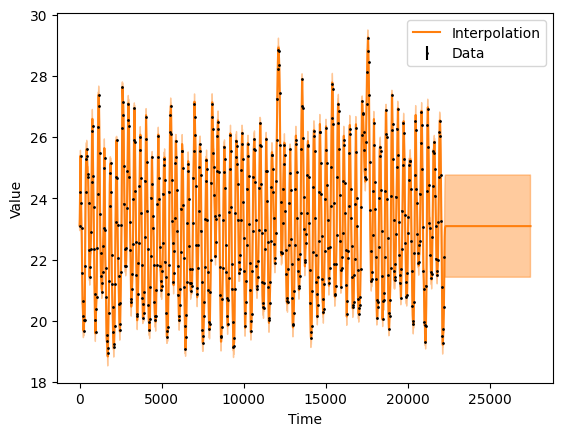

In [19]:
def visualize_model(ohp):
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    Parameters
    ----------


    Returns
    -------

    """
    gaussian_process_regression(time_data_days, y, t, ohp )


visualize_model(ohp)

## Fig3: This is the plot of the temperature and time of the original data points (black dots), interpolated line (orange line) and uncertainity (orange shade) with in GP calculated mean by GP calculated standared deviation. The reason for this plot is to see what the optimized hyperprameter of the kernel can improve the fit of the data points using GP. As seen the uncertaininy in the decreased in this plot.

In [ ]:
ExpSine2Kernel



(27500,) (27500,)
Optimized values: 3.09, 15.00


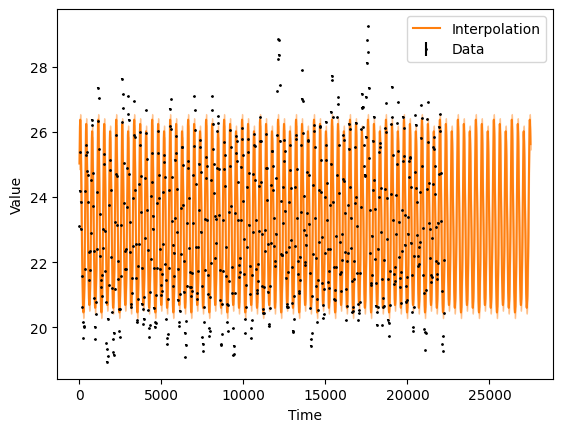

In [36]:
def gaussian_process_regression2(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """
    # a, b, c, d = initial_guess
    a, b, c= initial_guess
    # time_data = x
    # value_data = y
    kernel = c*kernels.ExpSine2Kernel( gamma= a, log_period=b)
    # kernel = a * kernels.CosineKernel(log_period=b) + c * kernels.ExpSquaredKernel(d)
    # kernel = a * kernels.CosineKernel(log_period=b) + kernels.ConstantKernel(log_constant=c)
    # kernel = a * kernels.CosineKernel(log_period=b)

    # Create the GP regression model
    gp = george.GP(kernel,white_noise=1e-8 )

    # Pre-compute the covariance matrix and optimize the GP hyperparameters
    gp.compute(time)
    gp.get_matrix(x)
    # Define a time grid for interpolation
    time_interp = t[:27500]

    # Perform GP regression to interpolate values at time_interp
    mean_interp, std_interp = gp.predict(data, time_interp, return_var=True)
    print(mean_interp.shape, std_interp.shape )
    optimized_values = gp.get_parameter_vector()
    print(f'Optimized values: {optimized_values[0]:.2f}, {optimized_values[1]:.2f}')

#     # Plot the original data and the GP interpolation
    plt.errorbar(time, data, yerr=0.01, fmt='ok', markersize=1, label='Data')
    plt.plot(time_interp, mean_interp, color='C1', label='Interpolation')
    plt.fill_between(time_interp, mean_interp - np.sqrt(std_interp), mean_interp + np.sqrt(std_interp), color='C1', alpha=0.4)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    # plt.xscale('log')
#     plt.figure(figsize=(240, 8))
    # plt.xlim(100,1550)
    plt.show()


initial_guess = 15,7,22
gaussian_process_regression2(time_data_days, y, t, initial_guess)


## Fig4: This is the plot of temperature and the time using GP with non stationary kernel to fit the extrapolated time points, and as seen the trend is continued. This plot is to see if the diffrent kernel can plot the points differently.